In [1]:
from collections import defaultdict
from dataclasses import dataclass
from decimal import Decimal
from datetime import date

import numpy as np
import pandas as pd
import pyfeng as pf

from yabte.backtest import (
    Asset,
    Strategy,
    StrategyRunner,
    PositionalOrder,
    OrderSizeType,
    Book,
    CashTransaction,
    Order,
)
from yabte.utilities.simulation.geometric_brownian_motion import gbm_simulate_paths

In [3]:
# TODO: track call premium mtm valuation using constant / stochastic volatility


@dataclass(kw_only=True)
class BSMOption(Asset):
    """Black Scholes Model Option"""

    K: float
    exp: date
    r: float = 0
    divr: float = 0
    cp: int = 1

    @property
    def fields_available_at_open(self):
        return ["Open", "IVol"]

    def intraday_traded_price(self, asset_day_data) -> Decimal:
        ts = asset_day_data.name
        bsm_option = pf.Bsm(sigma=asset_day_data.IVol, intr=self.r, divr=self.divr)
        t = (self.exp - ts).days / 100
        price = bsm_option.price(self.K, asset_day_data.Close, t)
        return round(Decimal(price), self.price_round_dp)


class DeltaHedgingStrat(Strategy):
    def init(self):
        # capture some data for analysis
        self.metrics = defaultdict(dict)

    def on_open(self):
        data = self.data
        p = self.params
        ts = self.ts

        # buy option on t0
        if len(data) == 1:
            self.orders.append(Order(asset_name="CO_ACME", size=1))

        # buy delta hedge shares
        t = (p.exp - ts).days / 100
        s = data.ACME.Open[-1]
        bsm_option = pf.Bsm(sigma=data.iloc[-1].loc["ACME"].IVol, intr=p.r, divr=0)
        delta = bsm_option.delta(p.K, s, t)
        gamma = bsm_option.gamma(p.K, s, t)

        self.orders.append(
            PositionalOrder(
                asset_name="ACME", size=-1 * delta, size_type=OrderSizeType.QUANTITY
            )
        )

        self.metrics[ts]["delta"] = delta
        self.metrics[ts]["gamma"] = gamma


# gbm params
r = 0.05
vol = 0.2
s0 = 100
N = 101
T = N / 365

# simulate data
rng = np.random.default_rng(12345)  # for reproducibility
ix = pd.date_range(end="20221231", periods=N, freq="D")
p = gbm_simulate_paths(mu=r, sigma=vol, R=1, T=T, n_steps=N, n_sims=1, rng=rng)
df = pd.DataFrame(s0 * np.c_[p[:, :, 0], p[:, :, 0]], index=ix)
df.columns = pd.MultiIndex.from_tuples((("ACME", "Open"), ("ACME", "Close")))

# add constant vol to data
df.loc[:, ("ACME", "IVol")] = vol

# assets
assets = [
    Asset(name="ACME", denom="USD", quantity_round_dp=6),
    BSMOption(name="CO_ACME", data_label="ACME", K=s0, exp=ix[-1], r=r),
]

# run simulation
book = Book(name="Main", cash="0", rate=0.05 / 100)
sr = StrategyRunner(
    data=df,
    assets=assets,
    strat_classes=[DeltaHedgingStrat],
    strat_params={
        "r": r,
        "vol": vol,
        "exp": ix[-1],
        "K": s0,
    },
    books=[book],
)
sr.run()

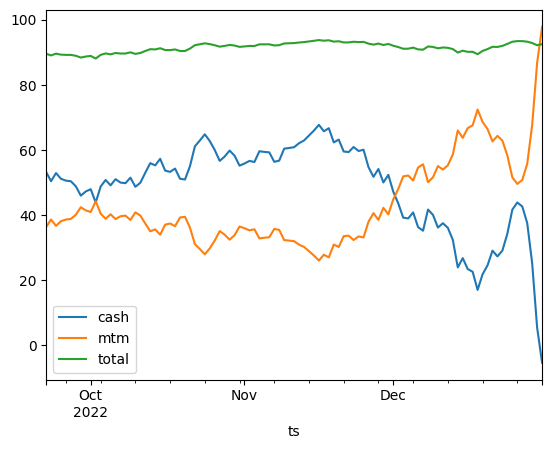

In [4]:
sr.book_history.Main.plot();

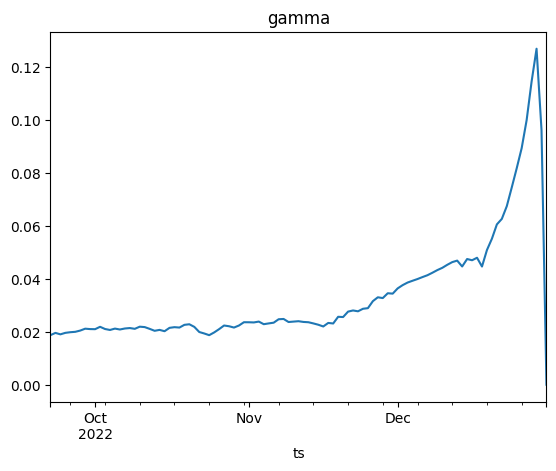

In [5]:
metrics = pd.DataFrame.from_dict(sr.strategies[0].metrics, orient="index").reindex(
    sr.book_history.index
)
metrics.gamma.plot(title="gamma");

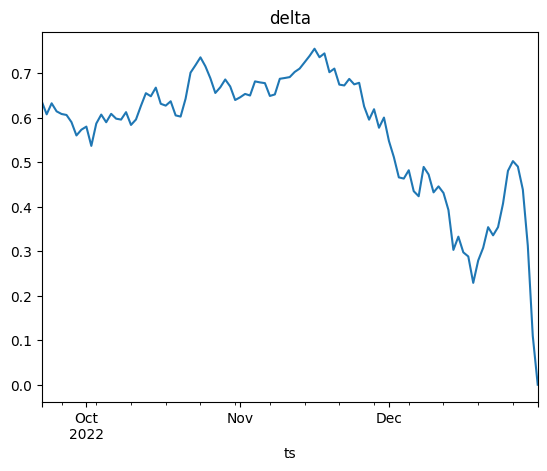

In [6]:
metrics.delta.plot(title="delta");

In [7]:
# total heding cost
sr.transaction_history[1:].total.sum()

Decimal('5.09635976')

In [8]:
with pd.option_context("display.max_rows", None):
    display(sr.transaction_history)

,ts,total,desc,quantity,price,asset_name,book
0,2022-09-22,-10.4500,buy CO_ACME,1.00,10.45,CO_ACME,Main
1,2022-09-22,63.68310000,sell ACME,-0.636831,100.00,ACME,Main
2,2022-09-22,0.027,interest payment on cash 53.23,NaN,NaN,NaN,Main
3,2022-09-23,-62.74059012,buy ACME,0.636831,98.52,ACME,Main
4,2022-09-23,59.87119512,sell ACME,-0.607706,98.52,ACME,Main
5,2022-09-23,0.025,interest payment on cash 50.39,NaN,NaN,NaN,Main
6,2022-09-24,-60.67336704,buy ACME,0.607706,99.84,ACME,Main
7,2022-09-24,63.14690304,sell ACME,-0.632481,99.84,ACME,Main
8,2022-09-24,0.026,interest payment on cash 52.89,NaN,NaN,NaN,Main
9,2022-09-25,-62.57767014,buy ACME,0.632481,98.94,ACME,Main
